# Breast Cancer Detection Model

    
    The data collected at baseline include breast ultrasound images among women in ages between 25 and 75 years old. This data was collected in 2018. The number of patients is 600 female patients. The dataset consists of 780 images with an average image size of 500*500 pixels. The images are in PNG format. The ground truth images are presented with original images. The images are categorized into three classes, which are normal, benign, and malignant.

* **Database**:
<div class="alert alert-block alert-success"> 
    <i>Al-Dhabyani W, Gomaa M, Khaled H, Fahmy A. Dataset of breast ultrasound images. Data in Brief.2020 Feb;28:104863. DOI: 10.1016/j.dib.2019.104863.</i>
</div>
<br>
* Validation Scores for Classification Model:
    <ul>
    <li><b>Accuracy</b>: <i>89.74 %</i></li>
    <li><b>Precision</b>: <i>90.1%</i></li>
    <li><b>Recall</b>**: <i>89.74%</i></li>
    <li><b>**F1**</b>: <i>89.80%</i></li>
    </ul>
<br>
* Validation Scores for Segmentation Model:

    <ul>
        <li><b>IoU</b>: <i>75.32%</i></li>
    </ul>

### Load modules

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import imageio
import os
import datetime
import seaborn as sns
import segmentation_models as sm

from glob import glob
from tensorflow.keras import backend

# Sklearn
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score

# Created Functions
from Helper_functions.helper_metric_functions import make_confusion_matrix
from Helper_functions.helper_metric_functions import plot_loss_curves, calculate_results
from Helper_functions.load_and_visualize_data import loadData, show_images
from Helper_functions.load_and_visualize_data import preprocess_classification_data
from Helper_functions.load_and_visualize_data import visualize_segmentation_and_classification
from Helper_functions.models import Attention_residual_unet_model, Classification_model
from Helper_functions.helper_loss_functions import jaccard_coef, jaccard_loss_function

# Tensorflow
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical


Segmentation Models: using `keras` framework.


In [2]:
sns.set()

### Hyperparameters

In [3]:
batch_size = 32
num_filters = 16 # Changed from 16
filter_multiplier = [4,4,8,16]
dropout = 0.2
batch_norm = True
kernel_size = 3
epochs = 500
learning_rate = 0.001
loss_func = jaccard_loss_function
size = 128
shape = (128, 128, 1)

### Analize the data

In [4]:
# root folder
root_path = "Dataset_BUSI_with_GT"

# classes in the analyzed data
classes = os.listdir(os.path.join(root_path, ""))
classes

['benign', 'malignant', 'normal']

In [5]:
# Amount of images
image_paths_bening = glob(root_path + "/" + f"{classes[0]}"+"/*).png")
image_paths_malignant = glob(root_path + "/" + f"{classes[1]}"+"/*).png")
image_paths_normal = glob(root_path + "/" + f"{classes[2]}"+"/*).png")
print(f"Total number of images is:\nNORMAL - {len(image_paths_normal)} \
                                  \nMALIGNANT - {len(image_paths_malignant)} \
                                  \nBENING - {len(image_paths_bening)}")

Total number of images is:
NORMAL - 133                                   
MALIGNANT - 210                                   
BENING - 437


#### Conlusions:
* We have highly unbalanced dataset, however the data show enough variation that this should not be a problem

### Load and preprocess data

In [6]:
train_data, test_data, X_train, X_test, y_train, y_test = loadData(path=root_path, files=True, 
                                                          batch_size=batch_size, size=size, split=0.10) 

Used memory to store the float image dataset is:  48.75
Used memory to store the float mask dataset is:  48.75


#### checking if the datas are normalized

In [7]:
X_train.min(), X_train.max(), X_test.min(), X_test.max()

(0.0, 1.0, 0.0, 1.0)

In [8]:
y_train.min(), y_train.max(), y_test.min(), y_test.max()

(0.0, 1.0, 0.0, 1.0)

#### Visualize the data

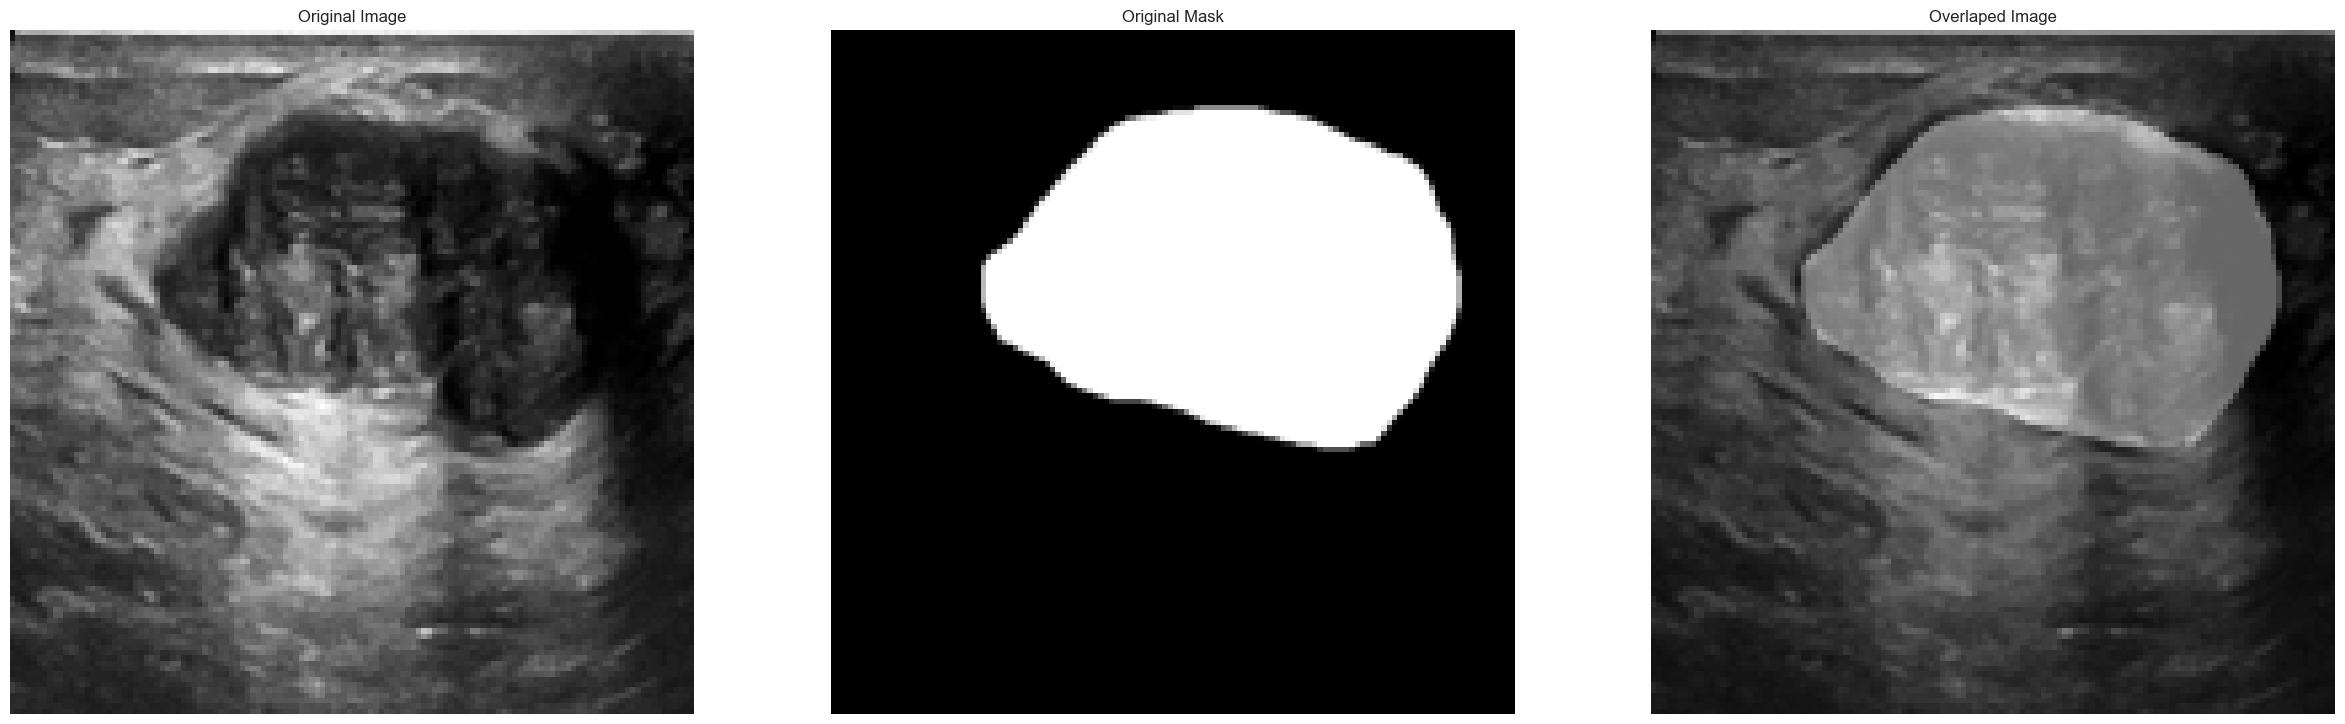

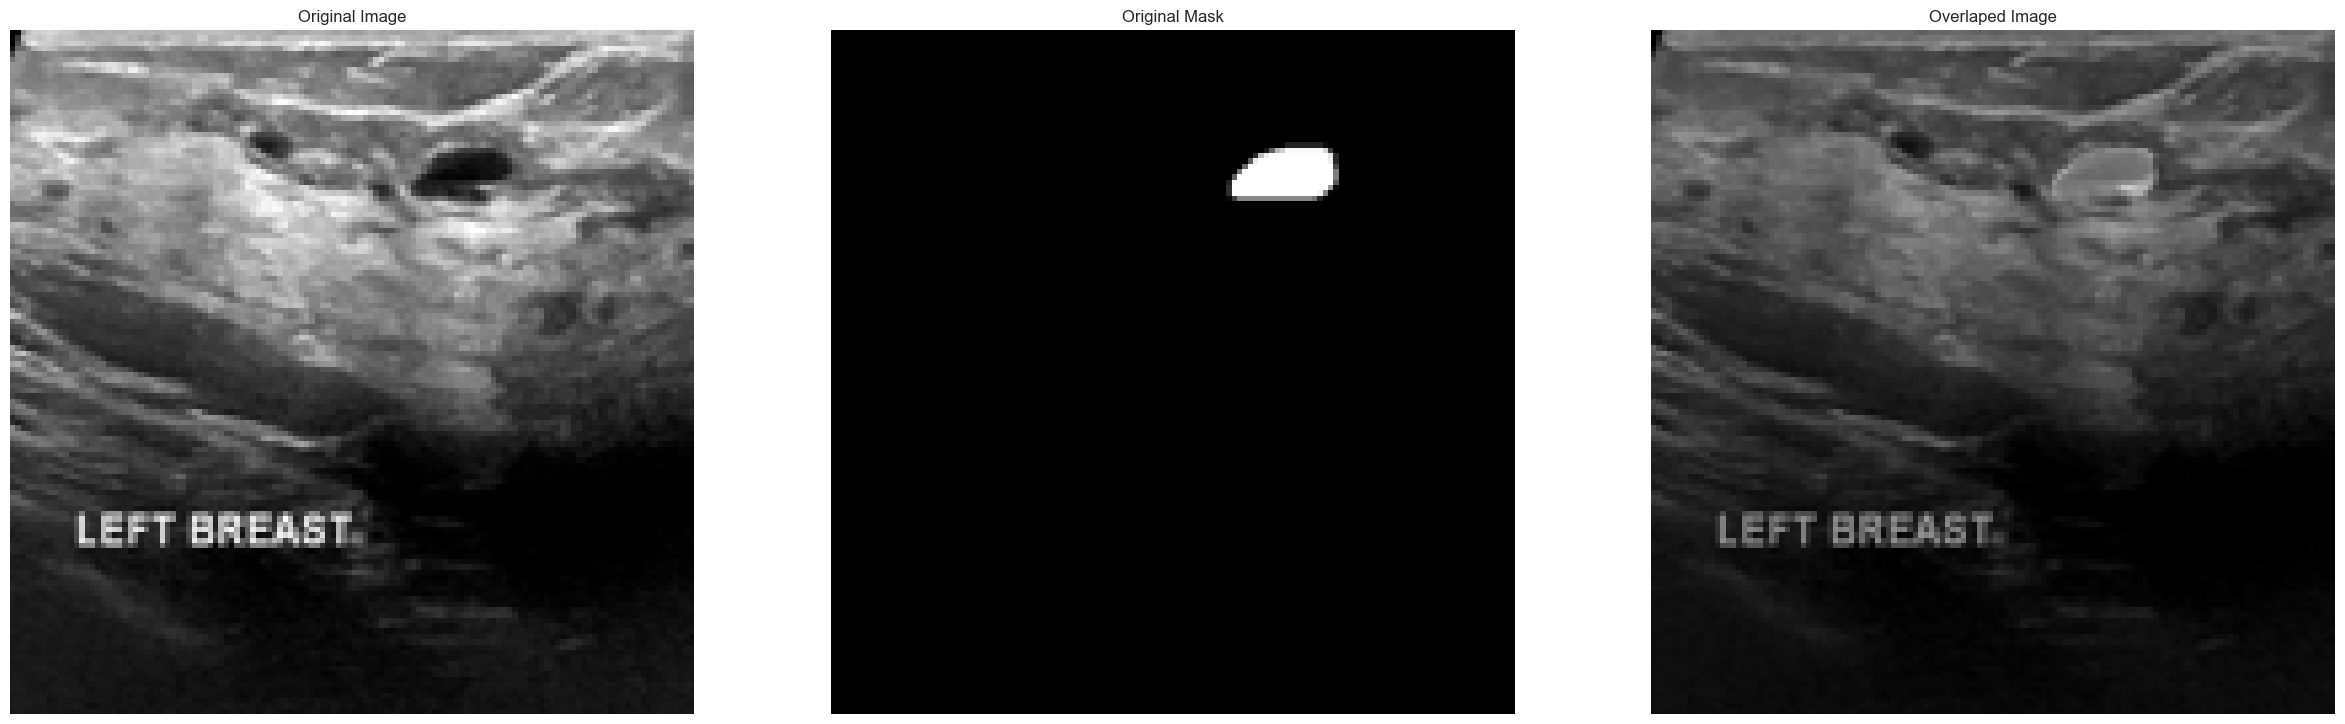

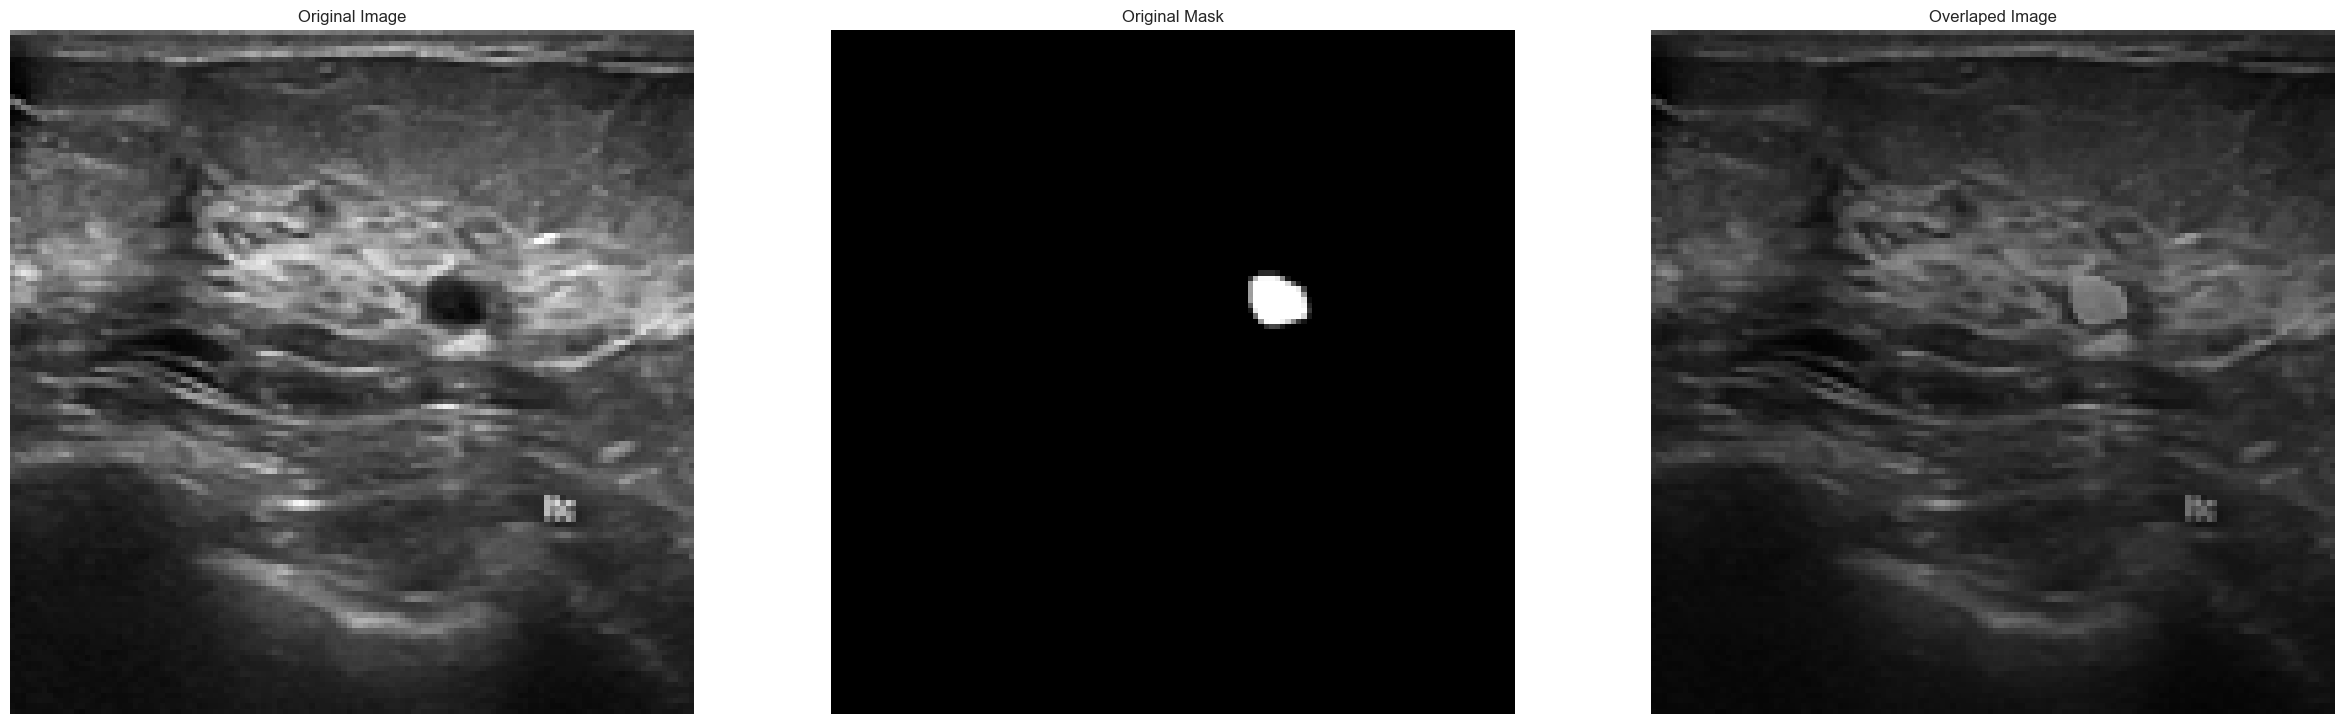

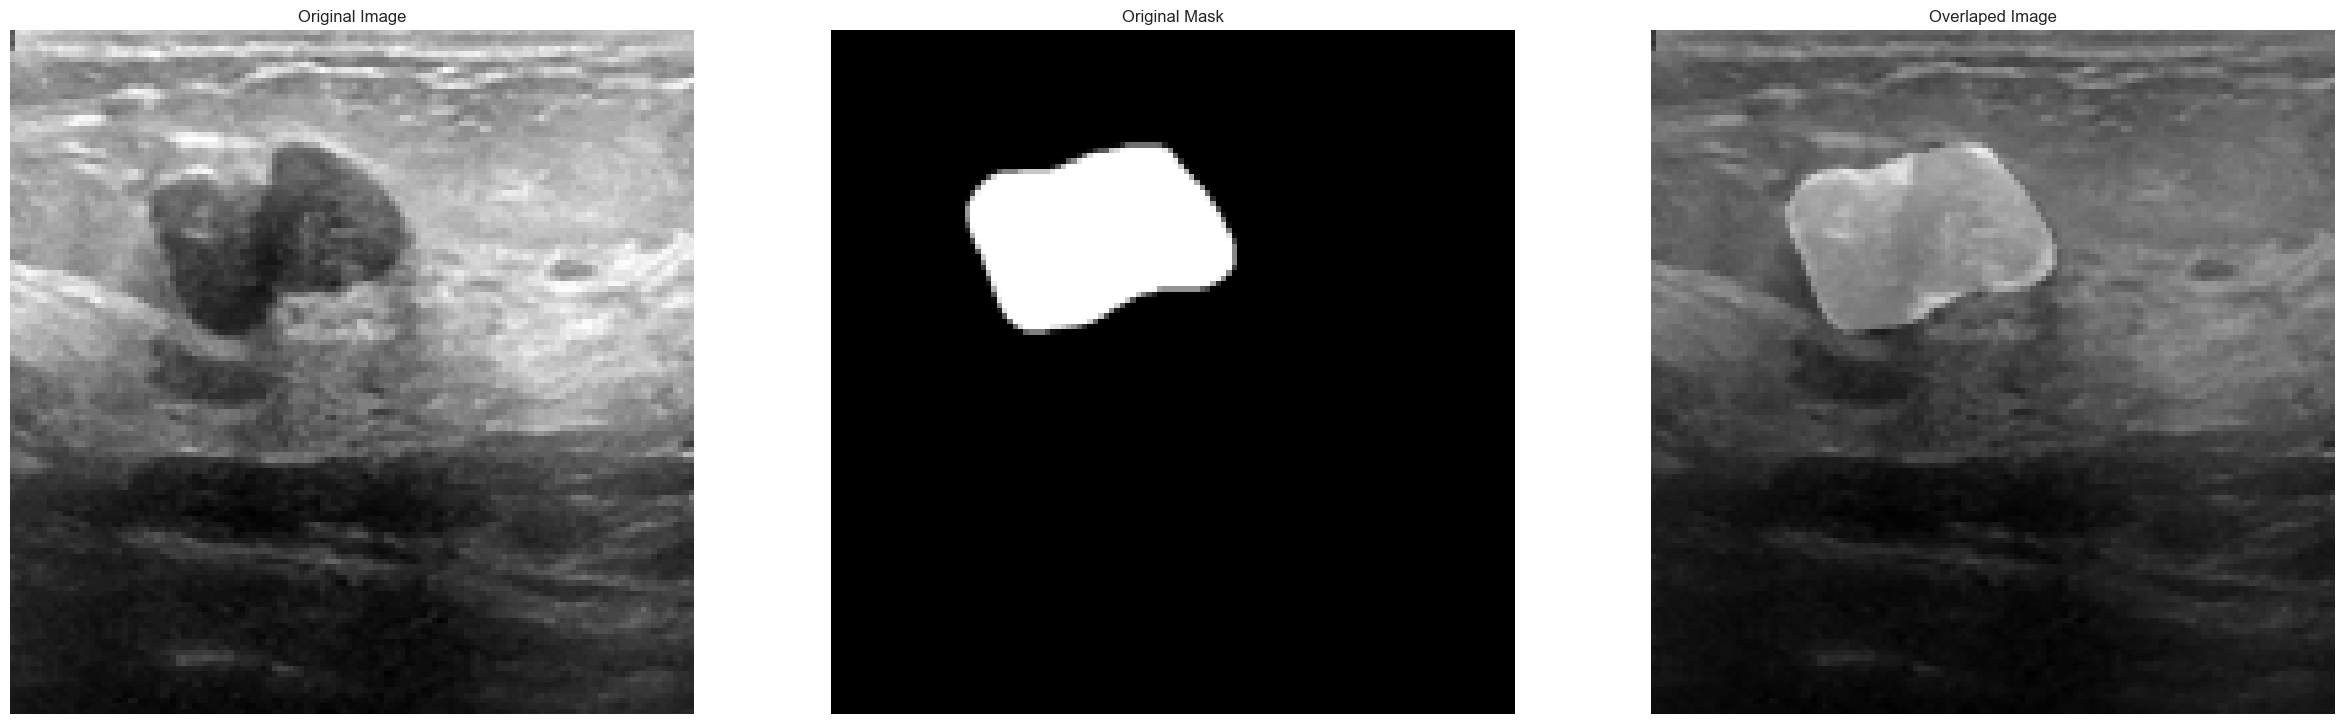

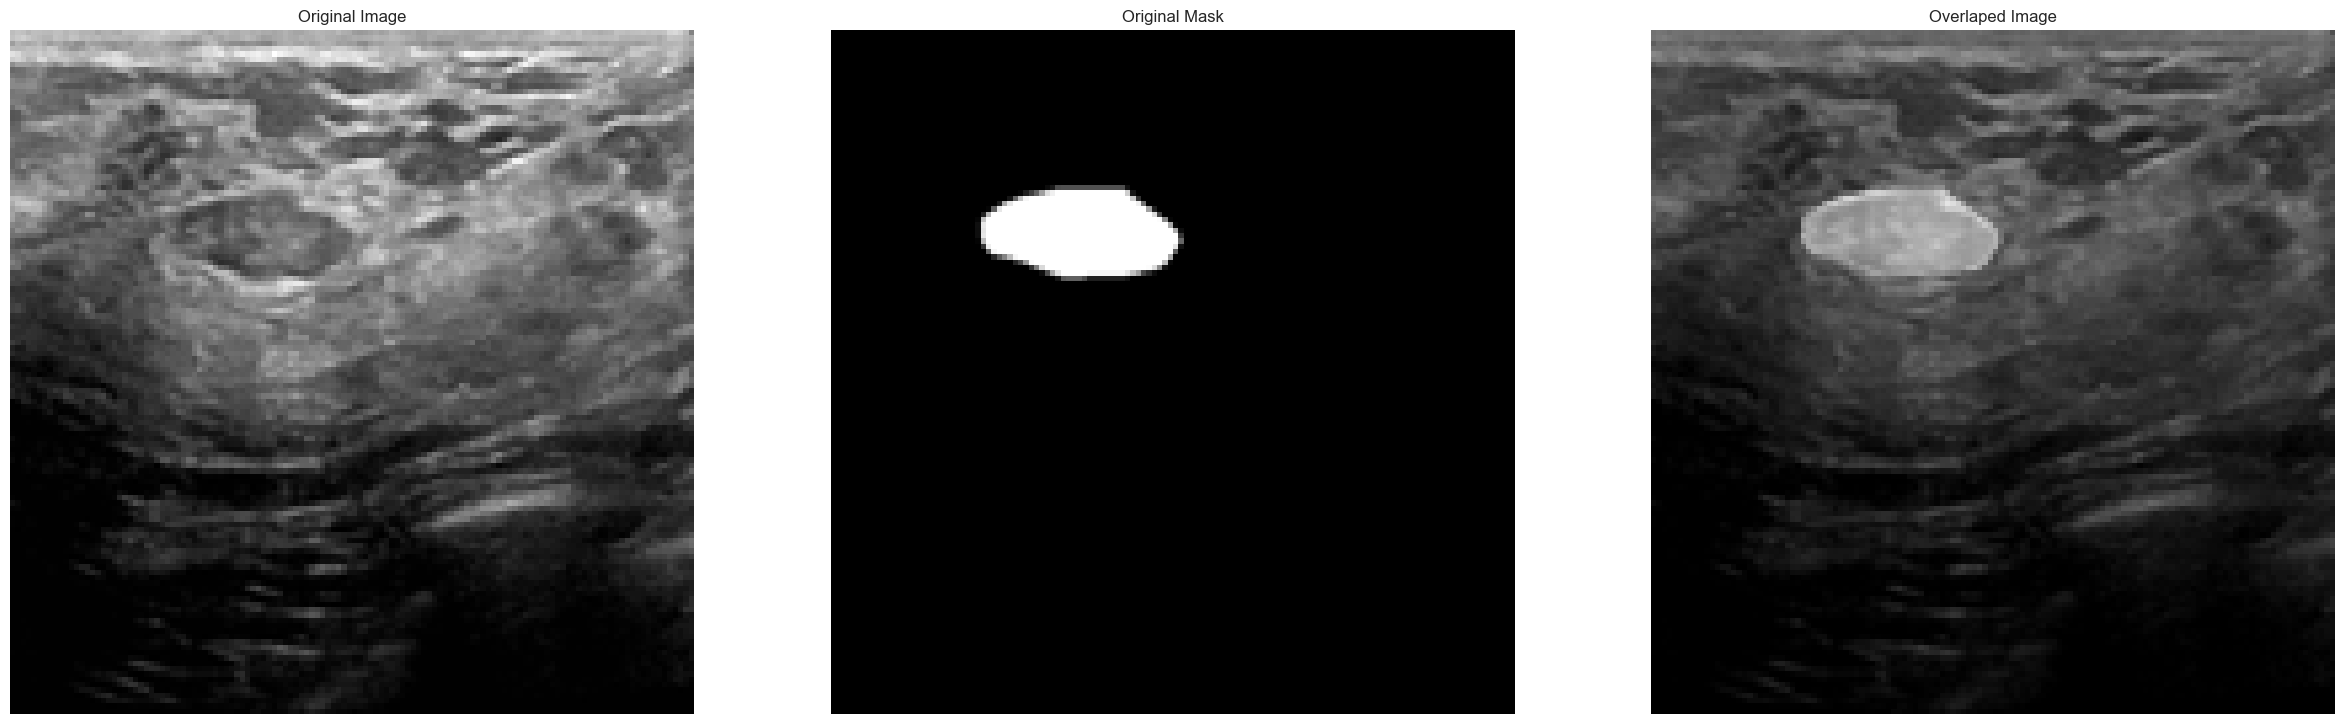

In [9]:
show_images(train_data)

#### Callbacks - Segmentation
 - ShowProgress
    * Creates model prediction during training process and visualize it
 - Tensorboard
    * Creates tensorborad which visualize different attempts to learnign process
 - Early Stopping
    * Stops training process if our model will not improve loss func after 15 epochs
 - Learning Rate Reducer
    * Reduce learning rate by sqrt(0.1) if the loss does not improve in 5 epochs
 - Model Checkpoint
    * Save model best weights and bias

In [10]:
# #Callback
# class ShowProgress(Callback):
#     def on_epoch_end(self, epoch, logs=None):
#         if (epoch+1)%5==0:
#             show_images(test_data, model=self.model, explain=True, n_images=2, SIZE=(25,10))

# def create_tensorboard_callback(dir_name, experiment_name):
#     """
#         Creates a TensorBoard callback instand to store log files.
#         Stores log files with the filepath:
#         "dir_name/experiment_name/current_datetime/"
#     Args:
#         dir_name: target directory to store TensorBoard log files
#         experiment_name: name of experiment directory (e.g. efficientnet_model_1)
#     """
#     log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
#     tensorboard_callback = tf.keras.callbacks.TensorBoard(
#       log_dir=log_dir)
#     print(f"Saving TensorBoard log files to: {log_dir}")
#     return tensorboard_callback

            
# # reduce learning rate by sqrt(0.1) if the loss does not improve in 5 epochs
# lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
#                                cooldown=0,
#                                patience=10,
#                                verbose=1,
#                                min_lr=0.5e-12)

# # save weights for future use (e.g. reload parameters w/o training)
# model_checkpoint = ModelCheckpoint(filepath="training_inzynierka/segmentation_model.h5",
#                              monitor='val_loss',
#                              verbose=1,
#                              save_best_only=True)

# # stop if our model doesn't improve
# early_stopping = EarlyStopping(monitor='val_loss',
#                                patience=30,
#                                mode='auto',
#                                restore_best_weights=True)

# callbacks = [ShowProgress(), early_stopping, lr_reducer, model_checkpoint, 
#              create_tensorboard_callback("training_data/segmentation_models")]

### Training part of Segmenation model

In [11]:
# attemption_residual_unet = Attention_residual_unet_model(shape = shape, 
#                                                          num_filters = num_filters,
#                                                          filter_multiplier = filter_multiplier,
#                                                          kernel_size = kernel_size,
#                                                          dropout = dropout,
#                                                          batch_norm = batch_norm,
#                                                          l_r = learning_rate,
#                                                          loss_func = loss_func)

In [12]:
# attemption_residual_unet.summary()

In [13]:
# history = attemption_residual_unet.fit(X_train, y_train, 
#                                        epochs = epochs, 
#                                        batch_size = batch_size, 
#                                        validation_data = (X_test, y_test), 
#                                        callbacks = callbacks,
#                                        verbose=1)

In [14]:
attemption_residual_unet = tf.keras.models.load_model("Model/Attention_Residual_Unet_29_excel.h5", custom_objects={
    "K": backend,
    "jaccard_loss_function": jaccard_loss_function,
    "iou_score" : sm.metrics.IOUScore(threshold=0.5)
})

C:\Users\ZEPHYRUS\anaconda3\lib\site-packages\keras\layers\core\lambda_layer.py:327: UserWarning: models_to_test is not loaded, but a Lambda layer uses it. It may cause errors.
  function = cls._parse_function_from_config(


### Check Results

* 1st column - Real Images
* 2st column - Images segmentated by Radiologists
* 3st column - Model Predictions
* 4st column - Overlapped image and model prediction
* 5st column - Places to which the model pays special attention

1/1 [==============================] - 3s 3s/step


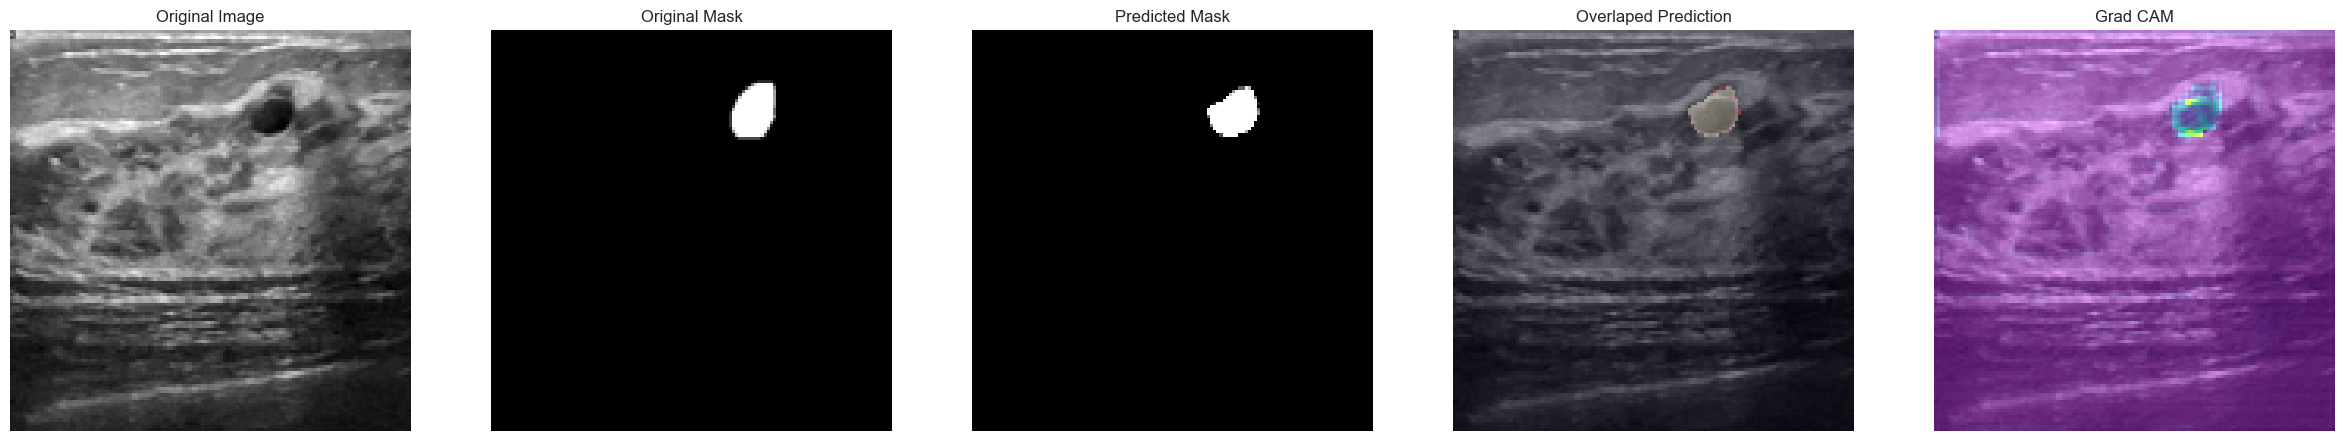

1/1 [==============================] - 0s 32ms/step


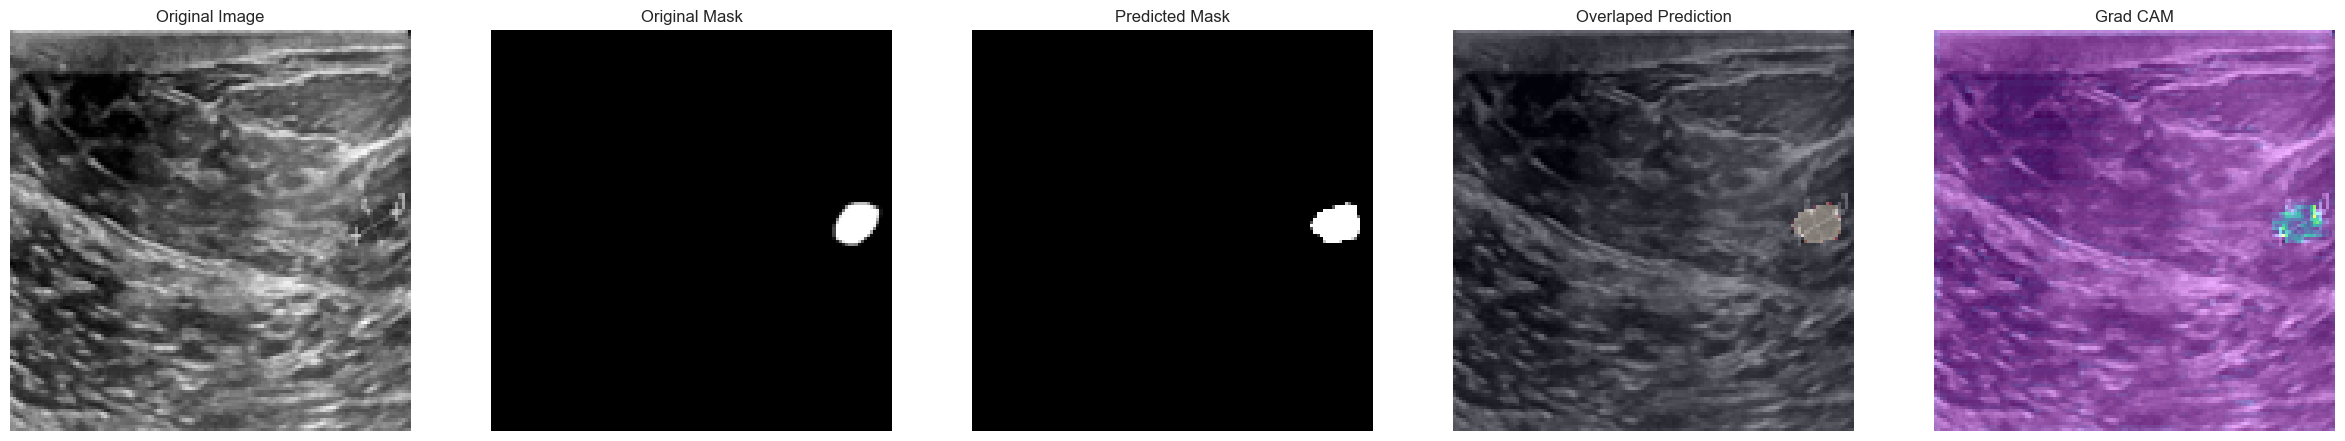

1/1 [==============================] - 0s 32ms/step


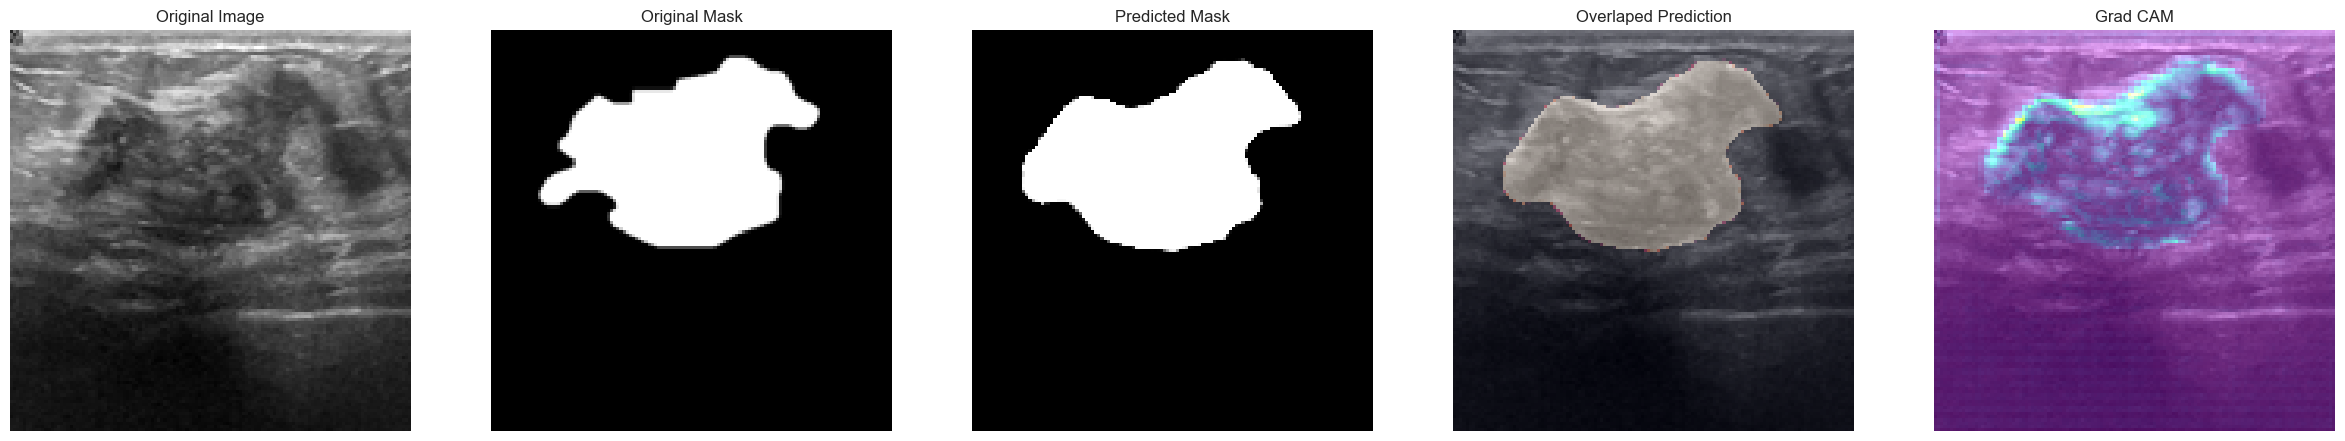

1/1 [==============================] - 0s 16ms/step


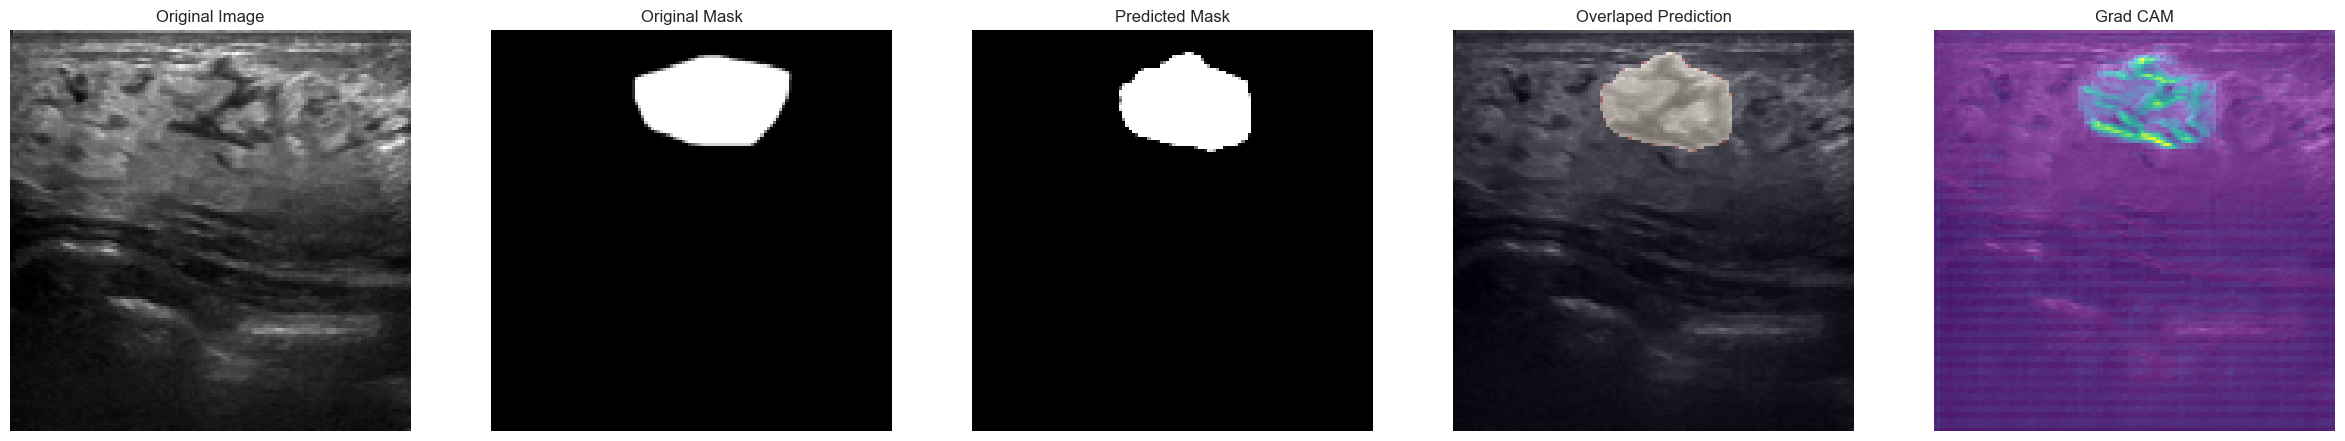

1/1 [==============================] - 0s 16ms/step


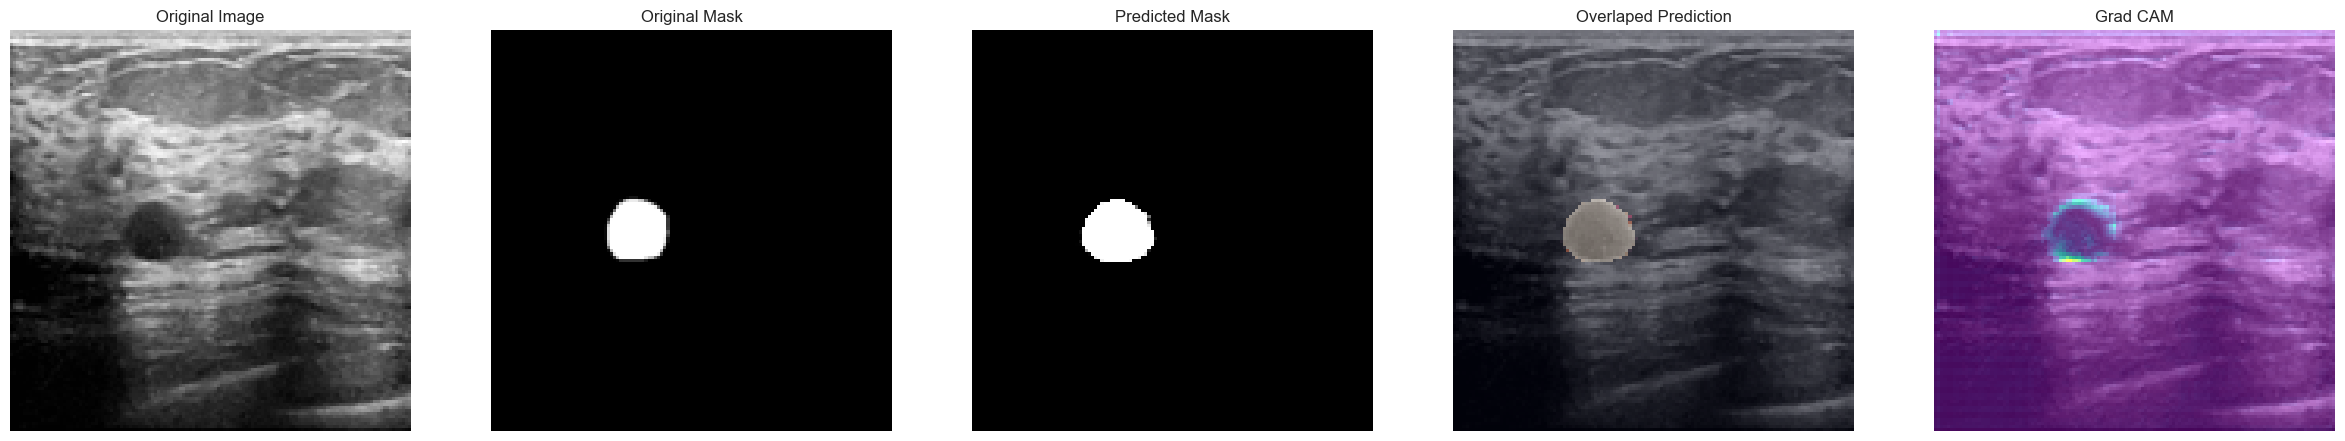

In [15]:
show_images(train_data, model=attemption_residual_unet, explain=True)

In [16]:
y_pred = attemption_residual_unet.predict(X_test) > 0.6

3/3 [==============================] - 2s 273ms/step


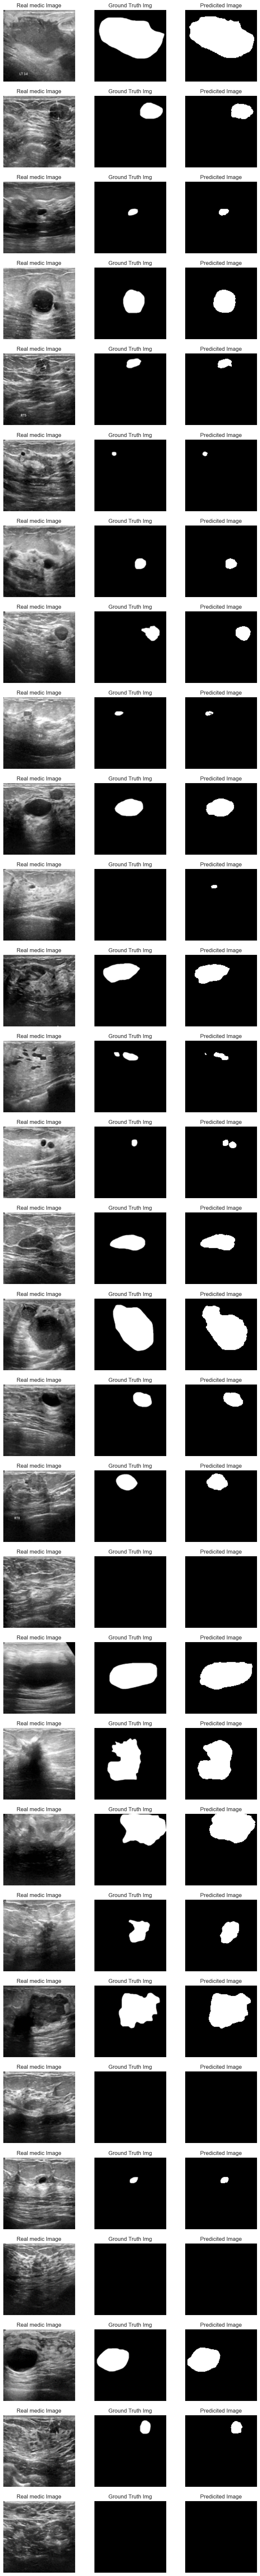

In [17]:
plt.figure(figsize = (10,100))

i = 0
x = 0
while i < 90 :
    
    plt.subplot(30,3,i+1)
    plt.imshow(X_test[x], 'gray')
    plt.title('Real medic Image')
    plt.axis('off')
    
    plt.subplot(30,3,i+2)
    plt.imshow(y_test[x], 'gray')
    plt.title('Ground Truth Img')
    plt.axis('off')
    
    plt.subplot(30,3,i+3)
    plt.imshow(y_pred[x], 'gray')
    plt.title('Predicited Image')
    plt.axis('off')
    
    x += 1
    i += 3
plt.show()

### Load and preprocess data for classification part

In [18]:
images, masks, labels, paths = loadData(root_path, classification_problem=True, size=128)

In [19]:
train_gen, X_train_c, X_test_c, y_train_c, y_test_c = preprocess_classification_data(images, labels)

In [20]:
info = [
    'benign'   ,  # 0
    'malignant'   ,  # 1
    'normal',  # 2
]

### Analyze and visualize the data

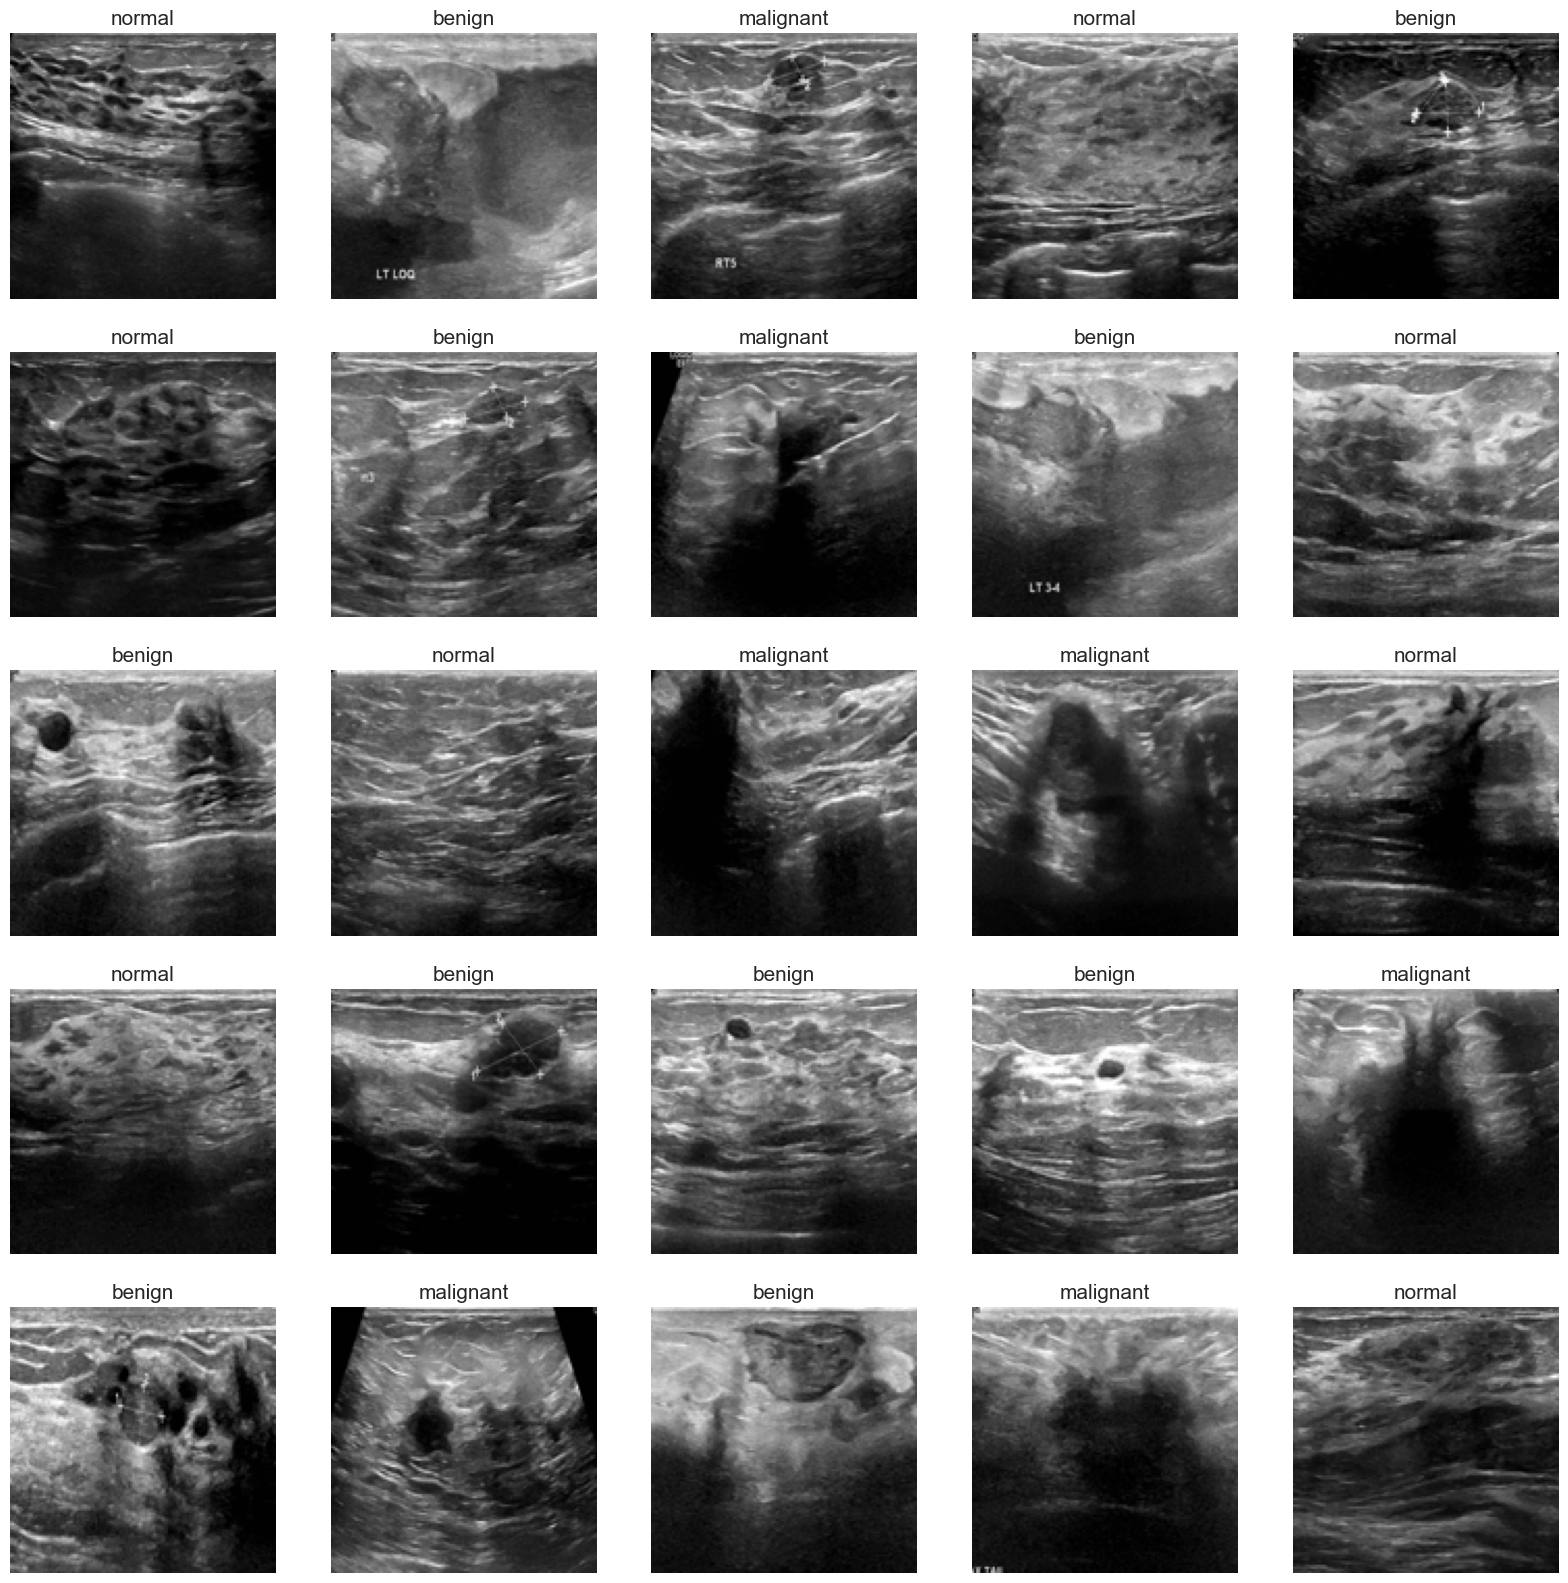

In [21]:
plt.figure(figsize = (20,20))
i = 0
SIZE = 702
while i < 25 :
    
    x = np.random.randint(0, SIZE)
    plt.subplot(5,5,i+1)
    plt.imshow(X_train_c[x], 'gray')
    plt.title(f'{info[np.argmax(y_train_c[x])]}', fontsize = 15)
    plt.axis('off')
    
    i += 1
plt.show()

#### Callbacks Classification
 - Early Stopping
    * Stops training process if our model will not improve loss func after 50 epochs
 - Learning Rate Reducer
    * Reduce learning rate by sqrt(0.1) if the loss does not improve in 30 epochs
 - Model Checkpoint
    * Save model best weights and bias

In [22]:
# def create_tensorboard_callback(dir_name, experiment_name):
#     """
#         Creates a TensorBoard callback instand to store log files.
#         Stores log files with the filepath:
#         "dir_name/experiment_name/current_datetime/"
#     Args:
#         dir_name: target directory to store TensorBoard log files
#         experiment_name: name of experiment directory (e.g. efficientnet_model_2)
#     """
#     log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
#     tensorboard_callback = tf.keras.callbacks.TensorBoard(
#       log_dir=log_dir)
#     print(f"Saving TensorBoard log files to: {log_dir}")
#     return tensorboard_callback

            
# # reduce learning rate by sqrt(0.1) if the loss does not improve in 5 epochs
# lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
#                                cooldown=0,
#                                patience=30,
#                                verbose=1,
#                                min_lr=0.5e-12)

# # save weights for future use (e.g. reload parameters w/o training)
# model_checkpoint = ModelCheckpoint(filepath="training_inzynierka/classification_model_2.h5",
#                              monitor='val_loss',
#                              verbose=1,
#                              save_best_only=True)

# # stop if our model doesn't improve
# early_stopping = EarlyStopping(monitor='val_loss',
#                                patience=50,
#                                mode='auto',
#                                restore_best_weights=True)

# callbacks = [early_stopping, lr_reducer, model_checkpoint]

### Training part for classification model

In [23]:
# classification_model = Classification_model(shape=(128, 128, 1), dropout=0.3)

In [24]:
# classifier_history = classification_model.fit(train_gen.flow(X_train_c, y_train_c, 32),
#                      batch_size=32,
#                      validation_data=(X_test_c, y_test_c),
#                      epochs=500,
#                      callbacks=callbacks)

In [25]:
classification_model = tf.keras.models.load_model("Model/classification_model_images.h5")

### Evaluate classification model

In [26]:
labels = np.array(labels)
labels = to_categorical(labels)

In [27]:
y_pred = classification_model.predict(images)

25/25 [==============================] - 2s 45ms/step


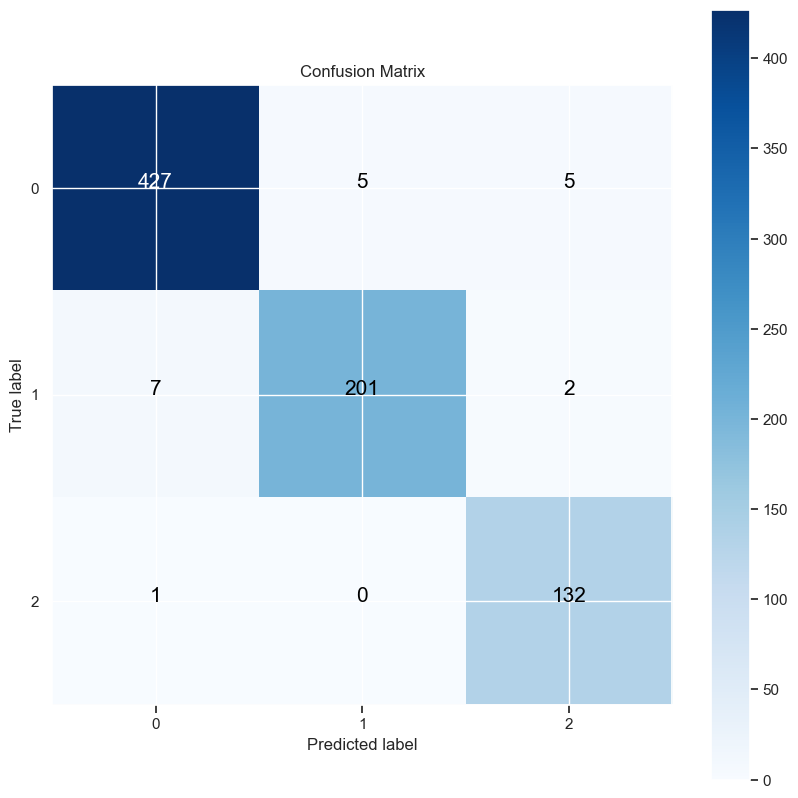

In [28]:
make_confusion_matrix(labels, y_pred)

In [29]:
calculate_results(labels, y_pred)

{'accuracy': 97.43589743589743,
 'precision': 0.974574729853263,
 'recall': 0.9743589743589743,
 'f1': 0.9743593402563782}

# Finish... Full models evaluation
* 1st column - Real Images
* 2st column - Images segmentated and labeled by Radiologists 
* 3st column - Model Predictions (Predicted label and masks)
* 4st column - Overlapped image and model prediction
* 5st column - Places to which the model pays special attention

<div class="alert alert-block alert-danger">
<b>Attention</b>: Both model and label are predicted by two separate models. If the label does not match the mask, it means that you need to pay special attention to this image.
</div>

25/25 [==============================] - 1s 41ms/step


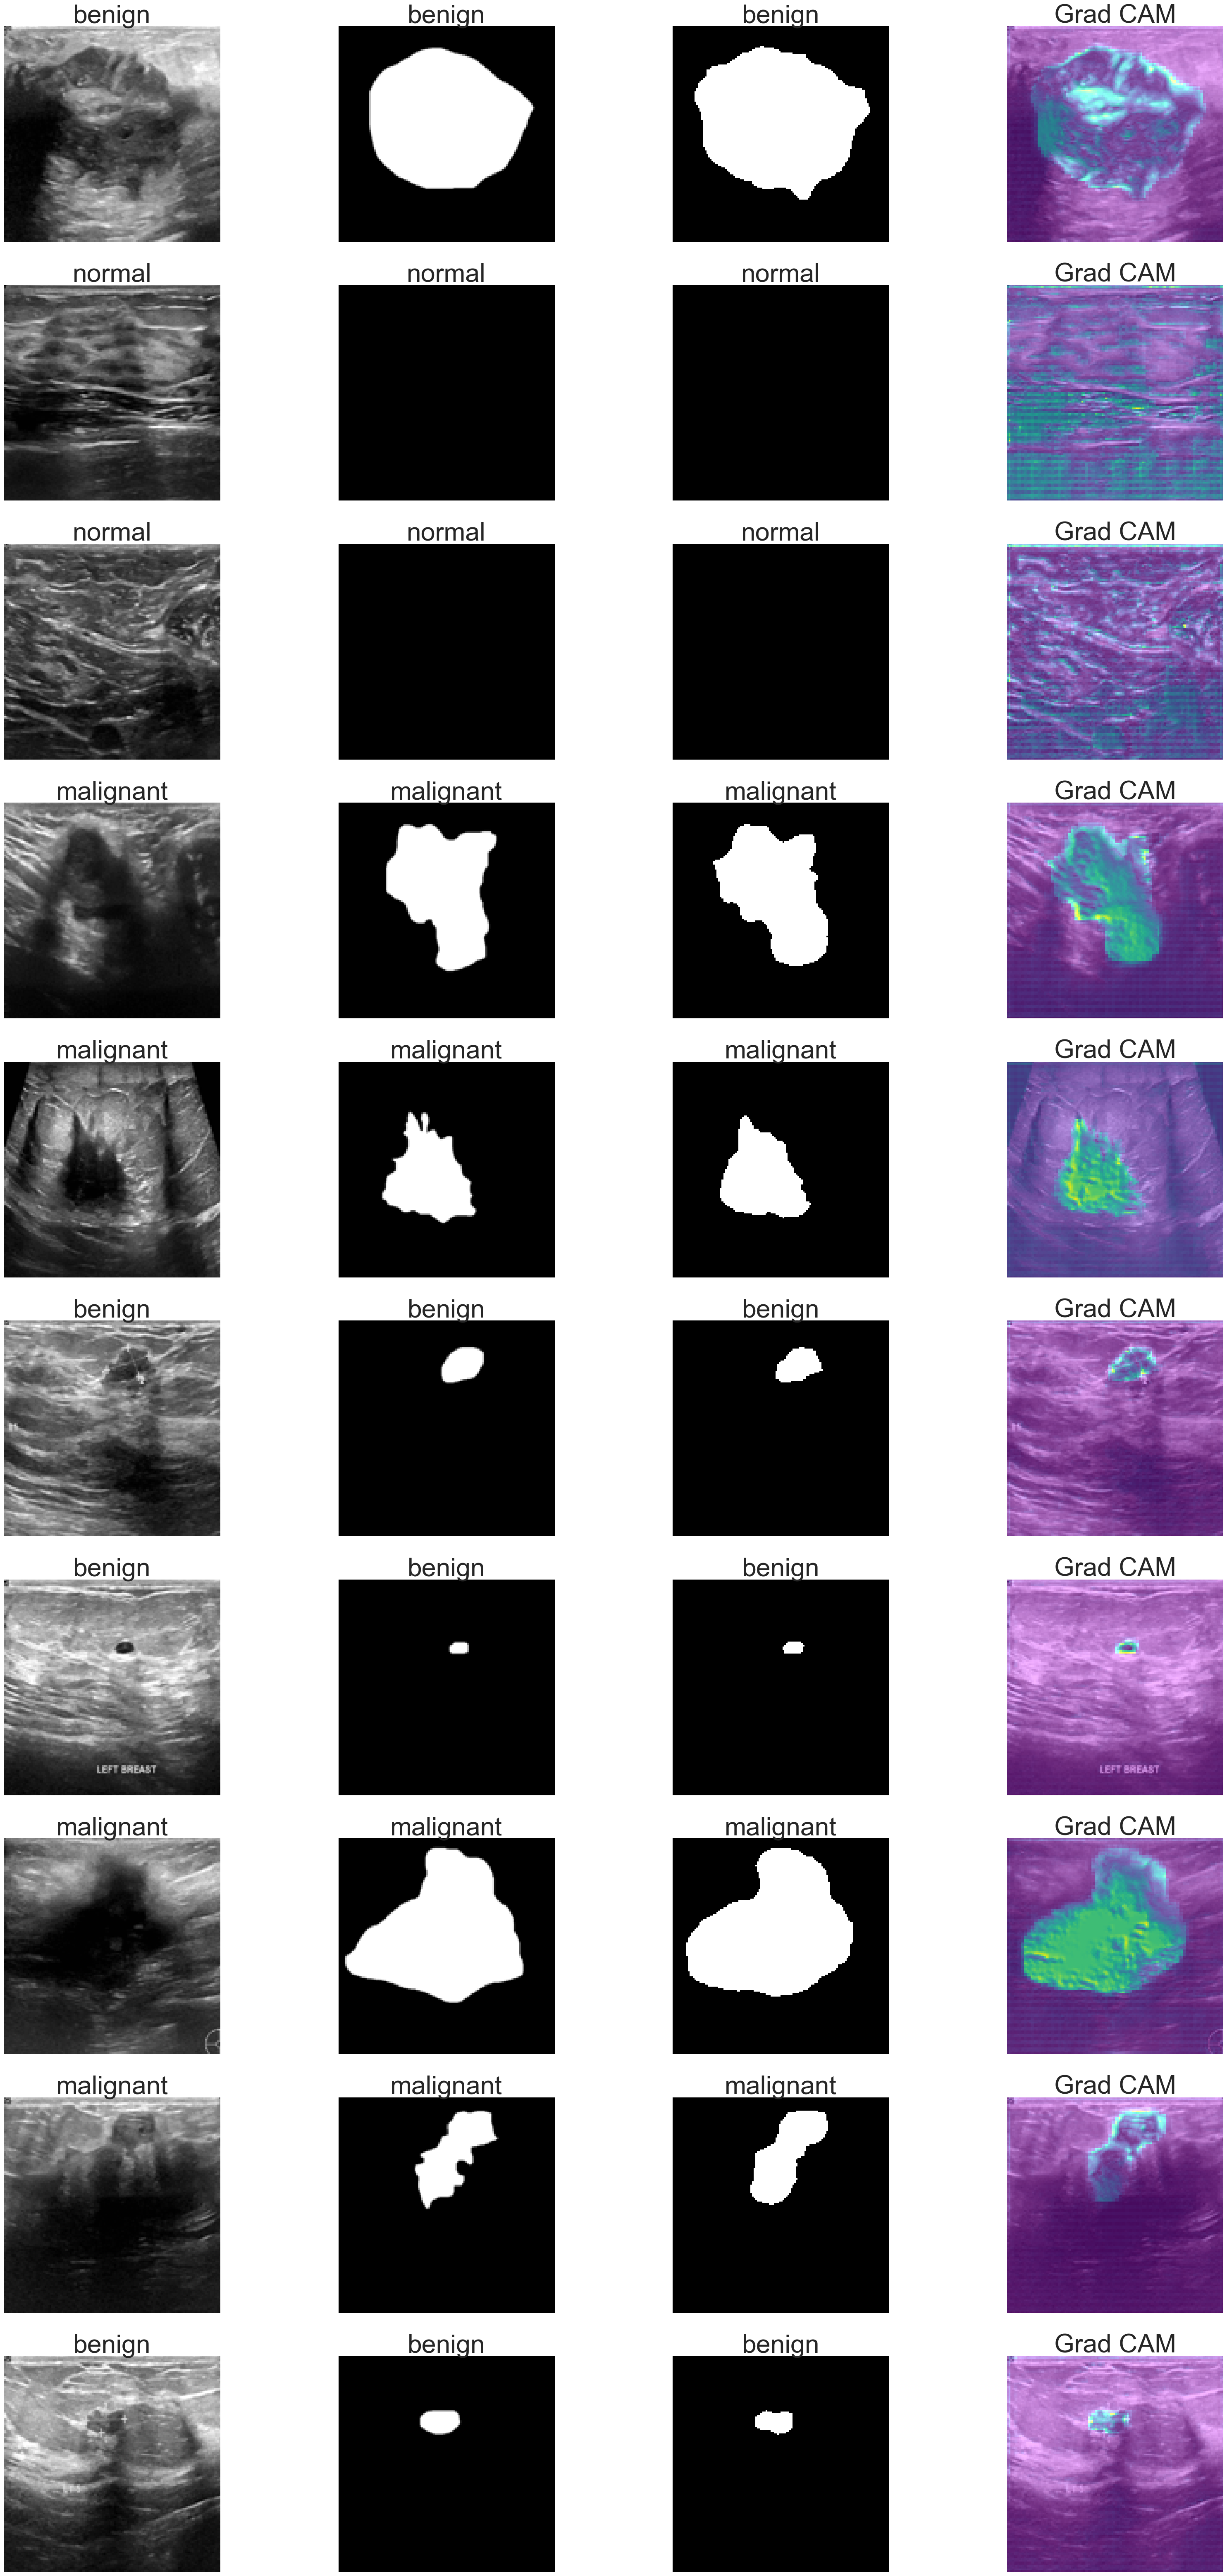

In [30]:
visualize_segmentation_and_classification(images, 
                                          masks, 
                                          labels,
                                          classification_model,
                                          attemption_residual_unet)

In [31]:
len(paths), len(np.argmax(labels, axis=1))

(780, 780)

In [32]:
info = ['benign', 'malignant', 'normal']
df_predictions = pd.DataFrame({"img": paths,
                               "y_true": np.argmax(labels, axis=1),
                               "y_pred": np.argmax(y_pred, axis=1),
                               "pred_probability": y_pred.max(axis=1),
                               "pred_prob>80%": y_pred.max(axis=1) > 0.8,
                               "y_true_classname": [info[np.argmax(i)] for i in labels],
                               "y_pred_classname": [info[np.argmax(i)] for i in y_pred]})

In [33]:
df_predictions.head()

img  y_true  y_pred  \
0    Dataset_BUSI_with_GT\benign\benign (1).png       0       0   
1   Dataset_BUSI_with_GT\benign\benign (10).png       0       0   
2  Dataset_BUSI_with_GT\benign\benign (100).png       0       0   
3  Dataset_BUSI_with_GT\benign\benign (101).png       0       0   
4  Dataset_BUSI_with_GT\benign\benign (102).png       0       0   

   pred_probability  pred_prob>80% y_true_classname y_pred_classname  
0          0.999047           True           benign           benign  
1          0.999752           True           benign           benign  
2          1.000000           True           benign           benign  
3          0.999998           True           benign           benign  
4          0.999059           True           benign           benign

In [34]:
df_wrong_predictions = df_predictions[df_predictions["y_true"] != df_predictions["y_pred"]] \
                                            .sort_values("pred_probability",
                                                          ascending=False)

In [35]:
the_most_fatal_mistakes = df_wrong_predictions[df_wrong_predictions['y_pred'] == 2]

In [36]:
the_most_fatal_mistakes

img  y_true  y_pred  \
436        Dataset_BUSI_with_GT\benign\benign (99).png       0       2   
90        Dataset_BUSI_with_GT\benign\benign (180).png       0       2   
636   Dataset_BUSI_with_GT\malignant\malignant (9).png       1       2   
583  Dataset_BUSI_with_GT\malignant\malignant (41).png       1       2   
268       Dataset_BUSI_with_GT\benign\benign (340).png       0       2   
227       Dataset_BUSI_with_GT\benign\benign (303).png       0       2   
305       Dataset_BUSI_with_GT\benign\benign (374).png       0       2   

     pred_probability  pred_prob>80% y_true_classname y_pred_classname  
436          0.951526           True           benign           normal  
90           0.903746           True           benign           normal  
636          0.799243          False        malignant           normal  
583          0.707712          False        malignant           normal  
268          0.595981          False           benign           normal  
227          0.594675          False           benign           normal  
305          0.580024          False           benign           normal

In [37]:
from Helper_functions.load_and_visualize_data import loadImageV2
from tensorflow.keras.preprocessing.image import img_to_array

In [53]:
x = loadImageV2("Dataset_BUSI_with_GT/benign/benign (374).png", 128)
x = img_to_array(x).astype(np.float32) / 255.
x = np.expand_dims(x, axis=0)
x_pred = attemption_residual_unet.predict(x) > 0.5

1/1 [==============================] - 0s 25ms/step


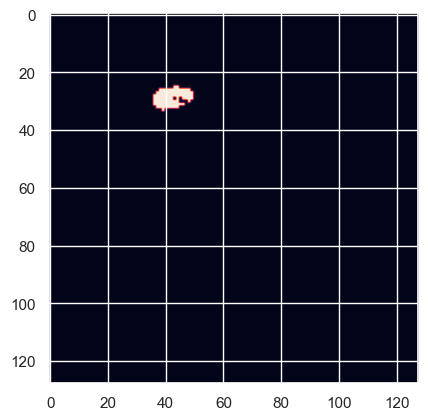

In [54]:
plt.imshow(x_pred[0]) 

### MCC , CAPPA SCORE - do walidacji modeli, próg ufności do modelu